In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

In [3]:
rnaseq_file = '../Data/raw_data/41467_2019_13483_MOESM4_ESM.xlsx'

# Basic data processing

In [4]:
metadata_df = pd.read_excel(rnaseq_file, sheet_name='Metadata')
print(metadata_df.shape)
metadata_df = metadata_df[metadata_df['Growth Rate (1/hr)'].isnull() == False]
print(metadata_df.shape)
metadata_df = metadata_df[metadata_df['Growth Rate (1/hr)'] > 0.0]
print(metadata_df.shape)
###OR
# metadata_df['Growth Rate (1/hr)'] = metadata_df['Growth Rate (1/hr)'].replace(0.0, np.NaN)
# print(metadata_df.shape)
metadata_df = metadata_df[metadata_df['Alignment'] > 80]
print(metadata_df.shape)

(278, 26)
(195, 26)
(179, 26)
(173, 26)


In [5]:
expression_df = pd.read_excel(rnaseq_file, sheet_name='Expression Data', index_col=0)
print(expression_df.shape)
expression_df = expression_df[metadata_df['Sample ID']]
print(expression_df.shape)
assert list(metadata_df['Sample ID']) == list(expression_df.columns)

(3923, 278)
(3923, 173)


# Dimensionality reduction techniques to assess associations with growth rate

What we're \*trying\* to do here is say that 4,xyz genes is simply too many to deal with. Can we condense these numbers into a more limited number of dimensions and then ask whether variation in any of those transformed dimensions are associated with growth rate?

"Limited" is arbitrary, so we can change the number of principal components to include/consider as well as the transformation kernel.

*Something else to consider is how and whether to standardize the values which can help with PCA in general.*

In [6]:
from sklearn.decomposition import PCA, KernelPCA
from scipy.stats import zscore

In [18]:
pca = PCA(n_components=10)
pca_transform = pca.fit_transform(expression_df.T.values)
print('PCA variance:\t\t', pca.explained_variance_ratio_)

explained_variance = np.var(expression_df.values.T, axis=0)
explained_variance_ratio = np.var(pca_transform, axis=0) / np.sum(explained_variance)
print('PCA variance by hand:\t', explained_variance_ratio)
print()
print('Total PCA variance:', np.sum(explained_variance_ratio))
print()
print('PCA shape:', pca_transform.shape)
print()
print('Correlations with growth rate (PCA index, correlation results):')
for i in range(pca_transform.shape[1]):
    print(i, stats.spearmanr(pca_transform[:,i], metadata_df['Growth Rate (1/hr)'], nan_policy='omit'))

PCA variance:		 [0.17868669 0.14011406 0.10637011 0.0797626  0.07526526 0.03916571
 0.02618565 0.02432209 0.02130139 0.01878229]
PCA variance by hand:	 [0.17868669 0.14011406 0.10637011 0.0797626  0.07526526 0.03916571
 0.02618565 0.02432209 0.02130139 0.01878229]

Total PCA variance: 0.7099558478559914

PCA shape: (173, 10)

Correlations with growth rate (PCA index, correlation results):
0 SpearmanrResult(correlation=-0.5117343892094286, pvalue=6.225942957627076e-13)
1 SpearmanrResult(correlation=0.42290201397067795, pvalue=6.7766152271492115e-09)
2 SpearmanrResult(correlation=0.1440604895186832, pvalue=0.05862980753303296)
3 SpearmanrResult(correlation=-0.2508107322809927, pvalue=0.0008736270685379527)
4 SpearmanrResult(correlation=0.2660693782156894, pvalue=0.0004028320340034326)
5 SpearmanrResult(correlation=-0.062950753436428, pvalue=0.4106207099696768)
6 SpearmanrResult(correlation=0.07572869570932637, pvalue=0.32204837211234844)
7 SpearmanrResult(correlation=-0.08586016767386705

In [40]:
kpca = KernelPCA(n_components=10, kernel='poly', degree=1)
kpca_transform = kpca.fit_transform(expression_df.values.T)
explained_variance = np.var(expression_df.values.T, axis=0)
explained_variance_ratio = np.var(kpca_transform, axis=0) / np.sum(explained_variance)
print('kPCA variance by hand:\t', explained_variance_ratio)
print()
print('Total kPCA variance:', np.sum(explained_variance_ratio))
print()
print('kPCA shape:', kpca_transform.shape)
print()
print('Correlations with growth rate (kPCA index, correlation results):')
for i in range(kpca_transform.shape[1]):
    print(i, stats.spearmanr(kpca_transform[:,i], metadata_df['Growth Rate (1/hr)']))

kPCA variance by hand:	 [4.55484798e-05 3.57160501e-05 2.71144815e-05 2.03320417e-05
 1.91856386e-05 9.98361104e-06 6.67490375e-06 6.19987122e-06
 5.42987293e-06 4.78773637e-06]

Total kPCA variance: 0.0001809726869446087

kPCA shape: (173, 10)

Correlations with growth rate (kPCA index, correlation results):
0 SpearmanrResult(correlation=-0.5117337961853782, pvalue=6.226387602529056e-13)
1 SpearmanrResult(correlation=0.422901523890139, pvalue=6.776915112060937e-09)
2 SpearmanrResult(correlation=0.14406032257400095, pvalue=0.05863010316804499)
3 SpearmanrResult(correlation=-0.25081044162865535, pvalue=0.0008736395669755845)
4 SpearmanrResult(correlation=0.26606906988085066, pvalue=0.00040283852537357324)
5 SpearmanrResult(correlation=-0.06295068048586701, pvalue=0.4106212533661363)
6 SpearmanrResult(correlation=0.07572860795103065, pvalue=0.3220489344918837)
7 SpearmanrResult(correlation=-0.0858600681747021, pvalue=0.2613519903273898)
8 SpearmanrResult(correlation=0.05893866860553212, 

**And just for fun, trying dimensionality reduction with a neural network based autoencoder**

But I'm still not sure how to preserve variance and thus quantify the success of an autoencoder

In [89]:
import tensorflow as tf
assert tf.__version__ >= "2.0"
print(tf.__version__)
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.random.set_seed(42)

from tensorflow import keras
print(keras.__version__)

from tensorflow.keras import layers

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

2.2.0
2.3.0-tf


In [114]:
X_all = expression_df.values.T
X_train, X_val = train_test_split(X_all, train_size = 0.8, random_state = 42)

print(X_all.shape, X_train.shape, X_val.shape)

# X_train = minmax_scale(X_train, axis = 0)
# X_val = minmax_scale(X_val, axis = 0)
print(X_all.shape, X_train.shape, X_val.shape)

(173, 3923) (138, 3923) (35, 3923)
(173, 3923) (138, 3923) (35, 3923)


In [129]:
# reduce to xyz features
encoding_dim = 10

input_df = layers.Input(shape=(X_all.shape[1],))
encoded = layers.Dense(encoding_dim, activation='elu')(input_df)
# encoded = layers.Dense(encoding_dim, activation='linear')(encoded)
# encoded = layers.Dense(encoding_dim*2, activation='elu')(encoded)
# encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dropout(0.5)(encoded)
decoded = layers.Dense(X_all.shape[1], activation='sigmoid')(encoded)

# encoder
autoencoder = keras.Model(input_df, decoded)

# intermediate result
encoder = keras.Model(input_df, encoded)

autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=32,
                validation_data=(X_val, X_val),
                verbose=0);

In [130]:
encoded_X_all = encoder.predict(X_all)
print(encoded_X_all.shape)
for i in range(encoding_dim):
    print(i, stats.spearmanr(encoded_X_all[:,i], metadata_df['Growth Rate (1/hr)']))

(173, 10)
0 SpearmanrResult(correlation=-0.4512910012031265, pvalue=4.621554132604088e-10)
1 SpearmanrResult(correlation=-0.4436773275345793, pvalue=9.731263713955468e-10)
2 SpearmanrResult(correlation=0.015772174776835273, pvalue=0.8368225834740041)
3 SpearmanrResult(correlation=0.1544121846745052, pvalue=0.04251601180115212)
4 SpearmanrResult(correlation=-0.2587246406450567, pvalue=0.0005881258799288646)
5 SpearmanrResult(correlation=-0.5152815636043364, pvalue=4.051435625928383e-13)
6 SpearmanrResult(correlation=-0.4246106855582904, pvalue=5.805249083969e-09)
7 SpearmanrResult(correlation=0.0021653992711398126, pvalue=0.9774428712790408)
8 SpearmanrResult(correlation=-0.2475046730083531, pvalue=0.0010269118436698496)
9 SpearmanrResult(correlation=-0.37757584860620375, pvalue=3.0380133222915266e-07)


In [171]:
dicty = metadata_df.groupby(['Study', 'Project ID', 'Condition ID'])['Sample ID'].apply(list).to_dict()

for i,j in dicty.items():
    print(j)
    
    
# metadata_df.groupby(['Study', 'Project ID', 'Condition ID'])['Growth Rate (1/hr)'].apply(list).to_dict()

['42c__42c_ale1__1']
['42c__42c_ale10__1']
['42c__42c_ale2__1']
['42c__42c_ale3__1']
['42c__42c_ale4__1']
['42c__42c_ale5__1']
['42c__42c_ale6__1']
['42c__42c_ale8__1']
['42c__42c_ale9__1']
['42c__wt_42c__1']
['cra_crp__delcra_ac__1', 'cra_crp__delcra_ac__2']
['cra_crp__delcra_fru__1', 'cra_crp__delcra_fru__2']
['cra_crp__delcra_glc__1', 'cra_crp__delcra_glc__2']
['cra_crp__wt_ac__1', 'cra_crp__wt_ac__2']
['cra_crp__wt_fru__1', 'cra_crp__wt_fru__2']
['pal__5drib_ale10__1']
['pal__5drib_ale10_f18__1', 'pal__5drib_ale10_f18__2']
['pal__arab_ale14__1', 'pal__arab_ale14__2']
['pal__arab_ale14_f9__1', 'pal__arab_ale14_f9__2']
['pal__arab_ale16__1', 'pal__arab_ale16__2']
['pal__lyx_ale2__1', 'pal__lyx_ale2__2']
['pal__lyx_ale2_f6__1']
['pal__lyx_ale4__1', 'pal__lyx_ale4__2']
['pal__tartr_ale26__1', 'pal__tartr_ale26__2']
['pal__tartr_ale26_f10__1', 'pal__tartr_ale26_f10__2']
['pal__tartr_ale28__1', 'pal__tartr_ale28__2']
['pal__tartr_ale28_f10__1', 'pal__tartr_ale28_f10__2']
['fps__fps_ptsI_

In [163]:
metadata_df.groupby()['Growth Rate (1/hr)'].mean()

Study          Project ID  Condition ID
42C Evolution  42c         42c_ale1        0.950
                           42c_ale10       0.980
                           42c_ale2        0.970
                           42c_ale3        0.920
                           42c_ale4        1.030
                                           ...  
yTF            ytf         delyiaJ         0.660
                           delyieP         0.665
                           wt_glc          0.685
                           wt_ph5          0.485
                           wt_ph8          0.650
Name: Growth Rate (1/hr), Length: 105, dtype: float64

In [157]:
metadata_df['Replicate #'].value_counts()

1    105
2     64
6      1
5      1
4      1
3      1
Name: Replicate #, dtype: int64

# Assess individual gene correlations with growth rate
 
How about clustering genes together?

Also there are some slight statistical issues here with treating replicates as independent experiments (they shouldn't be)

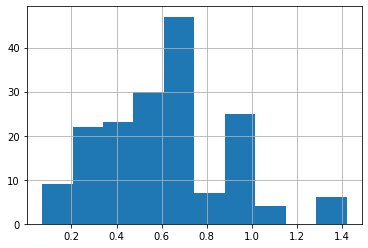

In [41]:
metadata_df['Growth Rate (1/hr)'].hist()

In [69]:
tempy = []
tempy_rando = []
for index in expression_df.index:
    rho, p = stats.spearmanr(expression_df.loc[index], metadata_df['Growth Rate (1/hr)'])
    tempy.append((index, rho, p))
    rho, p = stats.spearmanr(np.random.permutation(expression_df.loc[index].values), metadata_df['Growth Rate (1/hr)'])
    tempy_rando.append((index, rho, p))
tempy.sort(key=lambda x: x[1])
tempy_rando.sort(key=lambda x: x[1])

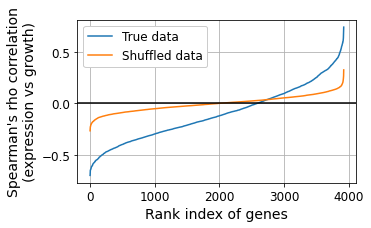

In [70]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot([i[1] for i in tempy], label='True data')
ax.plot([i[1] for i in tempy_rando], label='Shuffled data')
ax.axhline(0, c='k')
ax.set_xlabel('Rank index of genes', fontsize=14)
ax.set_ylabel('Spearman\'s rho correlation\n(expression vs growth)', fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12, framealpha=1)
ax.grid()

In [44]:
expression_df.head()

,fur__wt_fe__1,fur__wt_fe__2,fur__delfur_fe2__1,fur__delfur_fe2__2,omics__bw_ac__1,omics__bw_ac__2,omics__bw_fum__1,omics__bw_fum__2,omics__bw_glc__1,omics__bw_glc__2,...,efeU__menFentC_ale29__1,efeU__menFentC_ale29__2,efeU__menFentC_ale30__1,efeU__menFentC_ale30__2,efeU__menFentCubiC_ale36__1,efeU__menFentCubiC_ale36__2,efeU__menFentCubiC_ale37__1,efeU__menFentCubiC_ale37__2,efeU__menFentCubiC_ale38__1,efeU__menFentCubiC_ale38__2
log-TPM,,,,,,,,,,,,,,,,,,,,,
b0002,11.064810,10.779071,11.229767,11.214065,9.257348,9.182322,9.709213,9.672126,10.208587,10.218351,...,10.271327,10.276565,11.148538,11.170578,11.676604,11.726097,11.881529,11.923237,11.496410,11.552762
b0003,10.776984,10.597810,10.897938,10.861157,8.983408,8.943151,9.436004,9.394573,9.609637,9.677931,...,10.160291,10.116861,10.314322,10.392251,10.916426,10.909277,11.023924,11.038426,10.624301,10.764195
b0004,10.394971,10.113950,10.185151,10.164655,8.761690,8.779920,9.532673,9.534370,9.883558,9.870356,...,10.475069,10.434352,10.679541,10.723953,11.143310,11.112721,11.184795,11.241845,10.953206,11.001006
b0005,6.716069,6.410864,6.527653,6.136168,4.474204,4.720490,5.782102,5.326669,5.846675,5.972022,...,5.979079,5.705586,6.306120,6.291340,5.058537,4.835550,5.448097,5.757951,5.873964,5.808618
b0006,6.761813,6.816532,6.862147,6.817480,6.536457,6.439917,6.408731,6.276017,6.910200,6.843384,...,8.371287,8.322390,8.137515,8.071837,7.354131,7.365536,7.328101,7.314761,8.057750,8.105213


In [46]:
np.random.permutation(expression_df.values)

TypeError: permutation() takes no keyword arguments

**How about total reads?**

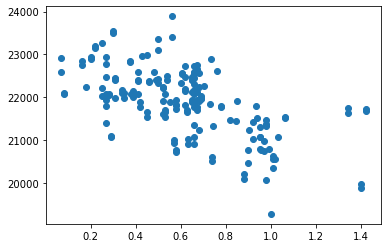

In [149]:
a = metadata_df['Growth Rate (1/hr)']
b = expression_df.sum()

fig, ax = plt.subplots()
ax.scatter(a,b)

# Incorporating external data sources

In [152]:
other_df = pd.read_csv('../Data/ecoli_info/temp_ecoli_master_table.tsv', sep='\t', index_col=0)
print(other_df.shape)
other_df = other_df[other_df['CAI'].isnull()==False]
print(other_df.shape)
other_df = other_df[other_df['roc_semppr_mean'].isnull()==False]
print(other_df.shape)
other_df = other_df[other_df['iCUB'].isnull()==False]
print(other_df.shape)
other_df = other_df[other_df['tAI'].isnull()==False]
print(other_df.shape)
other_df = other_df[other_df['stAIcalc'].isnull()==False]
print(other_df.shape)

(4355, 13)
(4310, 13)
(4310, 13)
(4310, 13)
(4310, 13)
(4310, 13)


In [153]:
other_df

,gene,start_loc,stop_loc,strand,cds_seq,us_seq,well_behaved,GC_percent_cds,roc_semppr_mean,iCUB,CAI,tAI,stAIcalc
locus_tag,,,,,,,,,,,,,
b0001,thrL,189,255,+,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,CAGATAAAAATTACAGAGTACACAACATCC,True,0.515152,1.244106,32.046035,0.617266,0.262286,0.258417
b0002,thrA,336,2799,+,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,TTTTCGACCAAAGGTAACGAGGTAACAACC,True,0.530654,1.034078,55.949262,0.353246,0.230564,0.216862
b0003,thrB,2800,3733,+,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,GTACCCTCTCATGGAAGTTAGGAGTCTGAC,True,0.562701,0.994168,56.062386,0.357812,0.216292,0.210420
b0004,thrC,3733,5020,+,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,ACGGCGGGCGCACGAGTACTGGAAAACTAA,True,0.528361,1.176750,53.052776,0.394675,0.231407,0.209784
b0005,yaaX,5233,5530,+,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,CATAACGGGCAATGATAAAAGGAGTAACCT,True,0.538721,0.837528,50.705530,0.374371,0.197715,0.208944
...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4399,creC,4636695,4638120,+,ATGCGTATCGGCATGCGGTTGTTGCTGGGCTATTTTTTACTGGTGG...,CGGCATGGGATATAGCCTGAGGGGCCTGTA,True,0.538947,0.829794,55.967103,0.293537,0.212672,0.206721
b4400,creD,4638177,4639530,+,ATGTTGAAATCCCCCCTGTTCTGGAAAATGACTAGCCTGTTTGGTG...,TATCCTGCTGCCATTGCAAAGGAGAAGACT,True,0.495935,0.739848,54.634345,0.288635,0.210078,0.199677
b4401,arcA,4639589,4640306,-,ATGCAGACCCCGCACATTCTTATCGTTGAAGACGAGTTGGTAACAC...,TCGATTTAGTTGGCAATTTAGGTAGCAAAC,True,0.510460,1.676448,48.981781,0.530773,0.275348,0.239921


In [154]:
print(expression_df.shape)
expression_df = expression_df[expression_df.index.isin(other_df.index)]
print(expression_df.shape)
other_df = other_df[other_df.index.isin(expression_df.index)]
print(other_df.shape)

(3923, 173)
(3859, 173)
(3859, 13)


In [155]:
expression_df = expression_df.sort_index()
other_df = other_df.sort_index()

## What metric correlates best with expression data?

In [173]:
metrics = ['GC_percent_cds', 'roc_semppr_mean', 'iCUB', 'CAI', 'tAI', 'stAIcalc']

for metric in metrics[:]:
    print(metric)
    tempy = []
    for column in expression_df.columns:
        tempy.append(stats.spearmanr(other_df[metric], expression_df[column])[0])
    print('Mean:', np.mean(tempy))
    print('Median:', np.median(tempy))
    print('Max:', np.max(np.abs(tempy)))
    print()

GC_percent_cds
Mean: 0.05470493491676735
Median: 0.04842152926979853
Max: 0.1808102950864034

roc_semppr_mean
Mean: 0.3957754416125814
Median: 0.3948306456620813
Max: 0.484170412507893

iCUB
Mean: -0.29614608151881755
Median: -0.2887424886286724
Max: 0.38153718617504284

CAI
Mean: 0.41321347461508845
Median: 0.41185137712741005
Max: 0.4772136685595271

tAI
Mean: 0.37615000279184263
Median: 0.37625149919776335
Max: 0.4325669145885162

stAIcalc
Mean: 0.33404045122335485
Median: 0.33485180228550554
Max: 0.3716422880846404



## How do metric *correlations* with expression in individual conditions correlate with growth rate?

In [187]:
metric = 'GC_percent_cds'
# metric = 'roc_semppr_mean'
# metric = 'iCUB'
# metric = 'CAI'
# metric = 'tAI'
# metric = 'stAIcalc'



tempy = []
listy_a = []
listy_b = []
for column in expression_df.columns:
    rho, p = stats.spearmanr(other_df[metric], expression_df[column])
    listy_a.append(rho)
    listy_b.append(metadata_df[metadata_df['Sample ID']==column].iloc[0]['Growth Rate (1/hr)'])
    tempy.append((column, rho, p))
tempy.sort(key=lambda x: x[1])

SpearmanrResult(correlation=0.28979487440542095, pvalue=0.0001100273726425804)


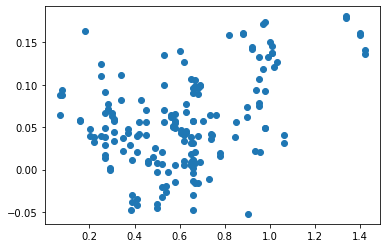

In [188]:
fig, ax = plt.subplots()
ax.scatter(listy_b, listy_a)
print(stats.spearmanr(listy_b, listy_a))

## Example correlations between metric and average expression

SpearmanrResult(correlation=0.4614061108752819, pvalue=8.763095745222825e-203)


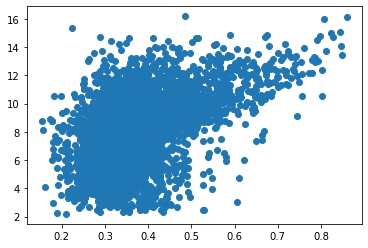

In [200]:
# metric = 'GC_percent_cds'
# metric = 'roc_semppr_mean'
# metric = 'iCUB'
metric = 'CAI'
# metric = 'tAI'
# metric = 'stAIcalc'

fig, ax = plt.subplots()
ax.scatter(other_df[metric], expression_df.max(axis=1))
print(stats.spearmanr(other_df[metric], expression_df.max(axis=1)))

# Quantify each individual gene's correlation with growth rate and assess its relationship/correlation with the codon metrics

In [203]:
import statsmodels.formula.api as smf

In [211]:
###Get correlation between expression and growth for each gene
listy = []
for index in expression_df.index:
    rho, p = stats.spearmanr(expression_df.loc[index], metadata_df['Growth Rate (1/hr)'])
    listy.append(rho)

In [214]:
# metric = 'GC_percent_cds'
# metric = 'roc_semppr_mean'
# metric = 'iCUB'
metric = 'CAI'
# metric = 'tAI'
# metric = 'stAIcalc'

# plot_df = pd.DataFrame(zip(other_df[metric], expression_df.mean(axis=1), listy))
# plot_df = pd.DataFrame(zip(other_df[metric], expression_df.median(axis=1), listy))
plot_df = pd.DataFrame(zip(other_df[metric], expression_df.max(axis=1), listy))

plot_df.columns = ['codon_metric', 'expression_summary', 'growth_summary']

fitted_model = smf.ols('codon_metric ~ expression_summary * growth_summary', data=plot_df).fit()
print(fitted_model.pvalues)
print(fitted_model.summary())

Intercept                            1.201398e-287
expression_summary                   2.085459e-248
growth_summary                        5.563325e-17
expression_summary:growth_summary     4.129076e-49
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           codon_metric   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     753.9
Date:                Wed, 06 Jan 2021   Prob (F-statistic):               0.00
Time:                        20:47:08   Log-Likelihood:                 4326.7
No. Observations:                3859   AIC:                            -8645.
Df Residuals:                    3855   BIC:                            -8620.
Df Model:                           3                                         
Covariance Type:            nonrobust                                 

In [6]:
# expression_df

,fur__wt_fe__1,fur__wt_fe__2,fur__delfur_fe2__1,fur__delfur_fe2__2,omics__bw_ac__1,omics__bw_ac__2,omics__bw_fum__1,omics__bw_fum__2,omics__bw_glc__1,omics__bw_glc__2,...,efeU__menFentC_ale29__1,efeU__menFentC_ale29__2,efeU__menFentC_ale30__1,efeU__menFentC_ale30__2,efeU__menFentCubiC_ale36__1,efeU__menFentCubiC_ale36__2,efeU__menFentCubiC_ale37__1,efeU__menFentCubiC_ale37__2,efeU__menFentCubiC_ale38__1,efeU__menFentCubiC_ale38__2
log-TPM,,,,,,,,,,,,,,,,,,,,,
b0002,11.064810,10.779071,11.229767,11.214065,9.257348,9.182322,9.709213,9.672126,10.208587,10.218351,...,10.271327,10.276565,11.148538,11.170578,11.676604,11.726097,11.881529,11.923237,11.496410,11.552762
b0003,10.776984,10.597810,10.897938,10.861157,8.983408,8.943151,9.436004,9.394573,9.609637,9.677931,...,10.160291,10.116861,10.314322,10.392251,10.916426,10.909277,11.023924,11.038426,10.624301,10.764195
b0004,10.394971,10.113950,10.185151,10.164655,8.761690,8.779920,9.532673,9.534370,9.883558,9.870356,...,10.475069,10.434352,10.679541,10.723953,11.143310,11.112721,11.184795,11.241845,10.953206,11.001006
b0005,6.716069,6.410864,6.527653,6.136168,4.474204,4.720490,5.782102,5.326669,5.846675,5.972022,...,5.979079,5.705586,6.306120,6.291340,5.058537,4.835550,5.448097,5.757951,5.873964,5.808618
b0006,6.761813,6.816532,6.862147,6.817480,6.536457,6.439917,6.408731,6.276017,6.910200,6.843384,...,8.371287,8.322390,8.137515,8.071837,7.354131,7.365536,7.328101,7.314761,8.057750,8.105213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4688,2.916383,3.248885,2.800527,2.039165,3.949532,3.257212,4.179527,4.054499,2.949236,3.450042,...,1.849193,2.272005,0.000000,1.283342,1.355421,1.167070,1.734880,1.007913,0.000000,1.545422
b4693,1.755932,2.136364,4.268691,4.252711,2.302745,1.583916,1.778959,2.486890,1.694740,2.202905,...,0.772861,2.004397,0.000000,0.333735,3.202295,3.001444,3.105540,3.091406,3.380939,3.171579
b4696_1,2.064534,2.014348,2.468705,2.431928,3.628631,3.736596,2.954142,2.836546,2.777701,2.979065,...,2.857578,2.874401,2.797063,2.578195,2.734153,2.718261,3.100377,3.021188,3.225358,3.401920


# Adventures in clustering

In [92]:
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, DBSCAN, OPTICS

from scipy.cluster import hierarchy

In [10]:
#Spearman correlation of conditions
condition_corr = expression_df.corr(method='spearman')
print(condition_corr.shape)
condition_corr.head()

(173, 173)


,fur__wt_fe__1,fur__wt_fe__2,fur__delfur_fe2__1,fur__delfur_fe2__2,omics__bw_ac__1,omics__bw_ac__2,omics__bw_fum__1,omics__bw_fum__2,omics__bw_glc__1,omics__bw_glc__2,...,efeU__menFentC_ale29__1,efeU__menFentC_ale29__2,efeU__menFentC_ale30__1,efeU__menFentC_ale30__2,efeU__menFentCubiC_ale36__1,efeU__menFentCubiC_ale36__2,efeU__menFentCubiC_ale37__1,efeU__menFentCubiC_ale37__2,efeU__menFentCubiC_ale38__1,efeU__menFentCubiC_ale38__2
fur__wt_fe__1,1.000000,0.996052,0.963706,0.963485,0.920567,0.919894,0.915651,0.913602,0.960286,0.961679,...,0.849489,0.850144,0.922285,0.930598,0.932191,0.938081,0.938491,0.941269,0.929753,0.922834
fur__wt_fe__2,0.996052,1.000000,0.962703,0.962414,0.922900,0.922577,0.918324,0.916052,0.960037,0.961047,...,0.846393,0.846562,0.919817,0.927784,0.927515,0.933182,0.933412,0.936131,0.928705,0.920489
fur__delfur_fe2__1,0.963706,0.962703,1.000000,0.996905,0.912404,0.912958,0.904385,0.902055,0.950829,0.951698,...,0.834489,0.833750,0.888814,0.901731,0.940483,0.943393,0.945141,0.946351,0.904708,0.903937
fur__delfur_fe2__2,0.963485,0.962414,0.996905,1.000000,0.911173,0.911780,0.902446,0.899954,0.950618,0.951611,...,0.831461,0.830588,0.885028,0.897943,0.937434,0.941021,0.943259,0.944290,0.901277,0.900799
omics__bw_ac__1,0.920567,0.922900,0.912404,0.911173,1.000000,0.995248,0.966034,0.964484,0.939546,0.940523,...,0.815925,0.815722,0.873928,0.878444,0.880243,0.885515,0.882385,0.883436,0.870208,0.864737


/Users/adamhockenberry/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


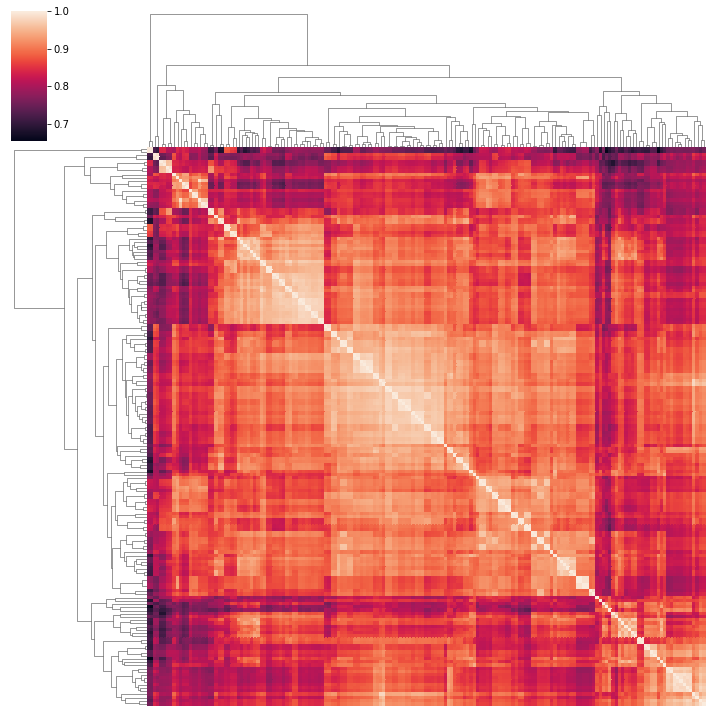

In [43]:
g = sns.clustermap(condition_corr, yticklabels=False, xticklabels=False)

In [57]:
g.dendrogram_col

In [147]:
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
tempy = cluster.fit_predict(expression_df.T.values)
print(tempy)

[3 3 3 3 2 2 2 2 3 3 2 2 2 2 2 2 2 2 3 3 3 3 5 5 5 5 3 1 1 1 1 1 1 1 1 1 1
 1 3 0 1 1 1 1 0 1 1 1 2 3 0 0 0 0 0 2 0 0 0 0 0 1 1 1 1 1 1 1 1 4 4 4 4 4
 4 5 5 3 3 4 4 4 4 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 3 3 0 0 0 0 3 3
 3 3 0 0 3 3 0 0 3 3 3 3 3 3 0 0 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 3 3 3 3 3 3 3 3]


0
32 0.7244062499999999
1
26 0.885769230769231
2
40 0.34063000000000004
3
45 0.6030033372444443
4
24 0.5344166666666667
5
6 1.0233333333333332


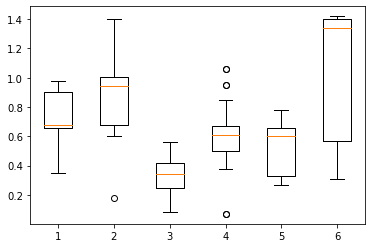

In [148]:
bp_d = []
for cluster_num in range(max(tempy)+1):
    print(cluster_num)
    ids = []
    for i, entry in enumerate(tempy):
        if entry == cluster_num:
            ids.append(i)
    print(len(ids), metadata_df.iloc[ids]['Growth Rate (1/hr)'].mean())
    bp_d.append(metadata_df.iloc[ids]['Growth Rate (1/hr)'])
    
fig, ax = plt.subplots()
ax.boxplot(bp_d);

In [153]:
metadata_df.columns

Index(['Sample ID', 'Study', 'Project ID', 'Condition ID', 'Replicate #',
       'Strain Description', 'Strain', 'Base Media', 'Carbon Source (g/L)',
       'Nitrogen Source (g/L)', 'Electron Acceptor', 'Trace Element Mixture',
       'Supplement', 'Temperature (C)', 'pH', 'Antibiotic', 'Culture Type',
       'Growth Rate (1/hr)', 'Evolved Sample', 'Isolate Type',
       'Sequencing Machine', 'Additional Details', 'Biological Replicates',
       'Alignment', 'DOI', 'GEO'],
      dtype='object')

In [155]:
metadata_df['Carbon Source (g/L)'].value_counts()

glucose(2)                70
glucose(4)                36
m-tartrate(2)              8
D-arabinose(2)             6
xylose(4)                  5
D-lyxose(2)                5
acetate(2)                 4
pyruvate(3.3)              4
fructose(2)                4
D-2-deoxyribose(2)         3
glucose(5)                 2
glycerol(2.5)              2
gluconate(4)               2
D-ribose(4)                2
acetate(4)                 2
glucarate(4)               2
sorbitol(4)                2
acetate(3.5)               2
N-acetylglucosamine(4)     2
galactose(4)               2
fumarate(2.8)              2
Name: Carbon Source (g/L), dtype: int64

# tempy

In [93]:
cluster = DBSCAN(eps=50, min_samples=1)
cluster.fit_predict(expression_df.T.values)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  2,
        2,  0,  0,  0,  0,  3,  3,  3,  3,  0,  4,  4,  5,  5,  6,  7,  7,
        7,  6,  6,  6,  8,  9,  7,  7, 10,  7, 11, 10,  7, 10, 12, 13, 14,
       15, 16, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 25, 25, 25, 25,
       25, 27, 27, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 27, 27, 32, 32,
       27, 27, 33, 33, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 34,
       34, 34, 34, 35, 36, 36, 36, 36, 37, 37, 38, 39, 39, 39, 39, 40, 40,
       41, 41, 41, 41, 42, 42, 43, 43, 44, 44, 45, 45, 46, 46,  0,  0,  0,
        0, 47, 47])

In [95]:
cluster = OPTICS(min_samples=2)
cluster.fit_predict(expression_df.T.values)

/Users/adamhockenberry/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_optics.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


array([ 0,  0, 22, 22, 21, 21, 20, 20, 18, 18, 19, 19, 45, 45, 46, 46, 53,
       53,  7,  7,  6,  6, 65, 65, 64, 64,  0, 54, 54, 63, 63, 37, -1, -1,
       -1, 37, 37, 37, -1, -1, -1, 35, 36, 35, -1, 36, 35, 36, -1, -1, -1,
       -1, 58, 58, -1, -1, -1, -1, -1, -1, -1, -1, 40, -1, 40, 39, 39, 39,
       39, 29, 29, 26, 26, 44, 44, 67, 67, 66, 66, 38, 38, 30, 30, 62, 62,
       28, 28, 43, 43, 31, 31, 27, 27, 32, 32, 33, 33, 34, 34, 11, 11, 13,
       13, 15, 15, 14, 14, 12, 12,  4,  4,  5,  5, -1, -1,  1,  1, 11, -1,
        3,  3,  5,  5,  2,  2, -1, -1,  8,  8,  9,  9, 10, 10, 23, 23, 41,
       41, 42, 42, -1, 60, 61, 60, 61, 59, 59, 59, 49, 49, 50, 50, 51, 51,
       56, 56, 57, 57, 55, 55, 52, 52, 47, 47, 48, 48, 25, 25, 17, 17, 16,
       16, 24, 24])